# Описание хода работы

Импортим нужные библиотеки

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

Загружаем данные и делаем предобработку и избавляем отсутствующие значения. Также разбивая датасет на 2 части.

In [4]:
train_data = pd.read_csv("../processed_train.csv")
valid_data = pd.read_csv("../processed_valid.csv")

# Предобработка данных
def preprocess_data(df):
    # Удаляем столбец 'report_date', если он существует
    if 'report_date' in df.columns:
        df = df.drop(columns='report_date')
    
    # Удаляем столбцы с большим количеством пропусков
    df = df.loc[:, df.isnull().mean() < 0.8]
    
    # Разделяем данные на классы
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]
    return df_target_0, df_target_1


Убираем все нечисловые столбцы. Заполняем пропуски нулями. Объединяем две части датасета в один

In [5]:
train_data = train_data.select_dtypes(exclude=["object"])
df_target_0, df_target_1 = preprocess_data(train_data)

valid_data = valid_data.select_dtypes(exclude=["object"])
df_target_2, df_target_3 = preprocess_data(valid_data)

Заполнение пропусков с использованием KNNImputer

In [6]:
df_filled_0 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_0), columns=df_target_0.columns)
df_filled_1 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_1), columns=df_target_1.columns)
combined_train = pd.concat([df_filled_0, df_filled_1])

df_filled_2 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_2), columns=df_target_2.columns)
df_filled_3 = pd.DataFrame(KNNImputer(n_neighbors=12).fit_transform(df_target_3), columns=df_target_3.columns)
combined_valid = pd.concat([df_filled_2, df_filled_3])

Нормализация данных. Разделение данных на обучающую и тестовую выборки

In [7]:
X_train = combined_train.drop(columns='target')
y_train = combined_train['target']

X_valid = combined_valid.drop(columns='target')
y_valid = combined_valid['target']

# Убедитесь, что признаки в X_valid совпадают с X_train
train_features = X_train.columns
extra_features = set(X_valid.columns) - set(train_features)
if extra_features:
    print(f"Лишние признаки в valid_data: {extra_features}")
    # Удаляем лишние признаки из X_valid
    X_valid = X_valid.drop(columns=extra_features)

missing_features = set(train_features) - set(X_valid.columns)
if missing_features:
    print(f"Отсутствующие признаки в valid_data: {missing_features}")
    # Добавляем отсутствующие признаки в X_valid с нулевыми значениями
    for feature in missing_features:
        X_valid[feature] = 0

# Упорядочиваем признаки в X_valid, чтобы они совпадали с X_train
X_valid = X_valid[train_features]

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)  # Масштабируем валидационные данные с помощью обученного scaler

# Балансировка классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Лишние признаки в valid_data: {'col1977', 'col485', 'col1999', 'col501', 'col2549', 'col481', 'col2439', 'col493', 'col1516', 'col2071', 'col1526', 'col489', 'col2297', 'col2584', 'col2367', 'col473', 'col509', 'col2047', 'col505', 'col2143'}
Отсутствующие признаки в valid_data: {'col2295', 'col2575', 'col2543'}


Обучение модели Градиентный бустинг (Gradient Boosting)

In [8]:
# Определяем модель для классификации
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Обучаем модель
xgb_model.fit(X_train, y_train)

# Предсказываем вероятности на валидационных данных
y_valid_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]  # Используем вероятности для класса 1

# Вычисляем AUC
auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print(f"AUC на валидационных данных: {auc_valid:.3f}")

# Вычисляем FPR, TPR и пороги для ROC-кривой
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)

AUC на валидационных данных: 0.836


Построение ROC-кривой с использованием matplotlib

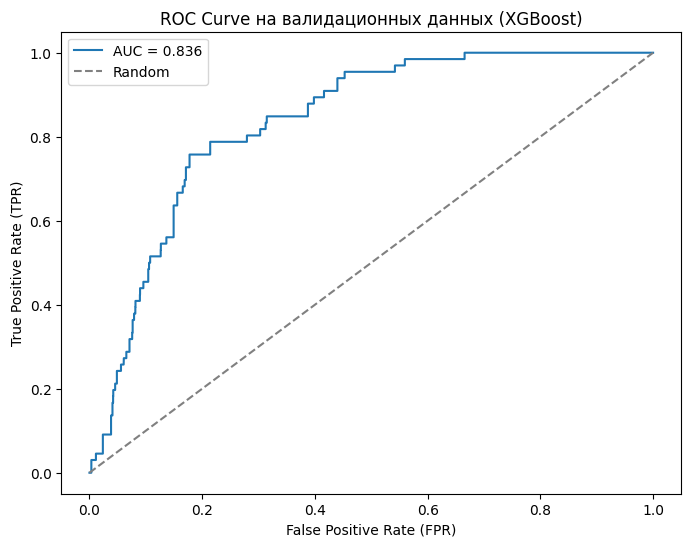

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_valid, tpr_valid, label=f'AUC = {auc_valid:.3f}')  # ROC-кривая модели
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')  # Случайная модель
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve на валидационных данных (XGBoost)')
plt.legend()
plt.show()